In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore')
RAND = 10

In [35]:
df = pd.read_csv('score.csv')
droplist = []
for i in range(2, 22):
    droplist.append('document_' + str(i) + '_flag')
    
df = df.drop(columns=droplist)
df_without_nan = df.dropna()
mode_values = df_without_nan.mode().iloc[0]
df_fill = df.fillna(mode_values)
df = df_fill

In [6]:
df.head()

,reco_id_curr,target,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,...,social_circle_defaults_30_days,observes_60_count_social_circle,social_circle_defaults_60_days,last_phone_number_change,requests_bki_hour,requests_bki_day,requests_bki_week,requests_bki_month,requests_bki_qrt,requests_bki_year
0,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,1.0,0.0,1.0
1,214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,...,0.0,2.0,0.0,-1071.0,0.0,0.0,0.0,1.0,0.0,3.0
2,142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,...,0.0,5.0,0.0,-1435.0,0.0,0.0,0.0,1.0,0.0,3.0
3,389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,...,0.0,0.0,0.0,-2000.0,0.0,0.0,0.0,0.0,0.0,0.0
4,283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,...,0.0,0.0,0.0,-173.0,0.0,0.0,0.0,0.0,0.0,4.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261384 entries, 0 to 261383
Columns: 102 entries, reco_id_curr to requests_bki_year
dtypes: float64(65), int64(21), object(16)
memory usage: 203.4+ MB


In [8]:
df.describe()

,reco_id_curr,target,children_count,income,loan_body,annuity_payment,goods_price,population_relative_region,days_birth,days_employed,...,social_circle_defaults_30_days,observes_60_count_social_circle,social_circle_defaults_60_days,last_phone_number_change,requests_bki_hour,requests_bki_day,requests_bki_week,requests_bki_month,requests_bki_qrt,requests_bki_year
count,261384.000000,261384.000000,261384.000000,2.613840e+05,2.613840e+05,261384.000000,2.613840e+05,261384.000000,261384.000000,261384.000000,...,261384.000000,261384.000000,261384.000000,261384.000000,261384.000000,261384.000000,261384.000000,261384.000000,261384.000000,261384.000000
mean,278231.764186,0.080762,0.417665,1.689238e+05,5.991866e+05,27106.220670,5.384866e+05,0.020884,-16034.247341,63867.624675,...,0.142740,1.398502,0.099597,-963.678791,0.005524,0.006087,0.029799,0.230860,0.229345,1.643884
std,102770.523515,0.272470,0.723263,2.537912e+05,4.023309e+05,14486.754575,3.691304e+05,0.013855,4365.115766,141317.267570,...,0.442552,2.296642,0.359601,826.880349,0.077945,0.103709,0.191634,0.854993,0.769455,1.856566
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25201.000000,-17912.000000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189205.750000,0.000000,0.000000,1.125000e+05,2.700000e+05,16527.375000,2.385000e+05,0.010006,-19682.000000,-2758.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278323.500000,0.000000,0.000000,1.485000e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15744.000000,-1213.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367161.250000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12407.000000,-289.000000,...,0.000000,2.000000,0.000000,-275.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,8.000000,47.000000,7.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [9]:
df['type_of_occupation'].isna().sum()

0

In [11]:

df['days_birth'] = df['days_birth'] /  - 365.
df['days_birth']

0         36.430137
1         40.487671
2         49.060274
3         53.769863
4         55.690411
            ...    
261379    43.843836
261380    30.569863
261381    56.000000
261382    30.205479
261383    42.901370
Name: days_birth, Length: 261384, dtype: float64

Text(1.6026319444444415, 0.5, 'Density')

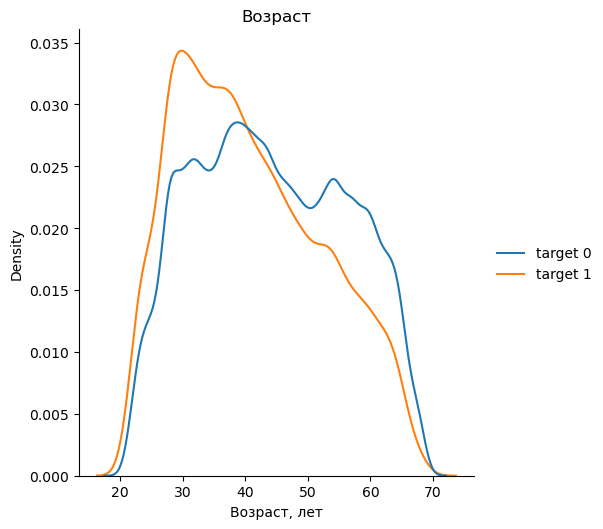

In [12]:
sns.displot({'target 0': df[df['target'] == 0]['days_birth'], 
            'target 1': df[df['target'] == 1]['days_birth']},
            kind = 'kde',
            common_norm=False)
plt.title('Возраст')
plt.xlabel('Возраст, лет')
plt.ylabel('Density')

In [13]:
df.groupby('target')['days_birth'].median()

target
0    43.482192
1    39.113699
Name: days_birth, dtype: float64

In [14]:
df.groupby('target')['days_birth'].mean()

target
0    44.205105
1    40.791882
Name: days_birth, dtype: float64

In [15]:
df['education_type_name'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Lower secondary', 'Incomplete higher', 'Academic degree'],
      dtype=object)

In [16]:
df.groupby('education_type_name')['days_birth'].median()

education_type_name
Academic degree                  43.410959
Higher education                 39.657534
Incomplete higher                31.571233
Lower secondary                  49.698630
Secondary / secondary special    44.775342
Name: days_birth, dtype: float64

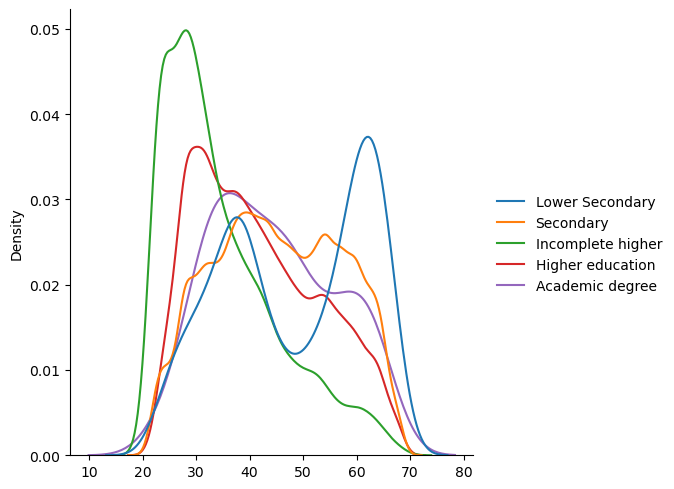

In [17]:
sns.displot(
    {
        'Lower Secondary': df[df['education_type_name'] == 'Lower secondary']['days_birth'],
        'Secondary': df[df['education_type_name'] == 'Secondary / secondary special']['days_birth'],
        'Incomplete higher': df[df['education_type_name'] == 'Incomplete higher']['days_birth'],
        'Higher education': df[df['education_type_name'] == 'Higher education']['days_birth'],
        'Academic degree': df[df['education_type_name'] == 'Academic degree']['days_birth']
    },
    kind='kde',
    common_norm=False
)

In [34]:
#на графике видны аномалии, связанные с уровнем образования

Text(28.21070486111111, 0.5, 'Density')

<Figure size 1200x2000 with 0 Axes>

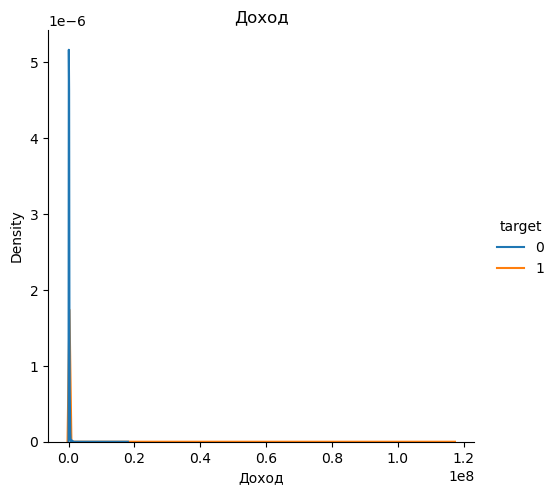

In [18]:
plt.figure(figsize=(12, 20))
sns.displot(df, x='income', hue='target', kind='kde', common_norm=False)
plt.title('Доход')
plt.xlabel('Доход')
plt.ylabel('Density')

In [19]:
df.groupby('target')['income'].mean()

target
0    169144.727621
1    166409.128351
Name: income, dtype: float64

Text(39.231513888888884, 0.5, 'Density')

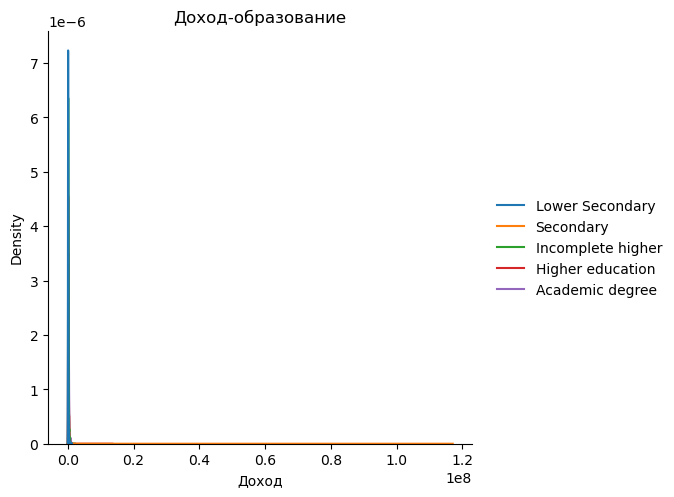

In [20]:
sns.displot(
    {
        'Lower Secondary': df[df['education_type_name'] == 'Lower secondary']['income'],
        'Secondary': df[df['education_type_name'] == 'Secondary / secondary special']['income'],
        'Incomplete higher': df[df['education_type_name'] == 'Incomplete higher']['income'],
        'Higher education': df[df['education_type_name'] == 'Higher education']['income'],
        'Academic degree': df[df['education_type_name'] == 'Academic degree']['income']
    },
    kind="kde",
    common_norm=False
)
plt.title('Доход-образование')
plt.xlabel('Доход')
plt.ylabel('Density')

In [21]:
df_label = pd.get_dummies(df, drop_first=True)

In [22]:
df_label.head()

,reco_id_curr,target,children_count,income,loan_body,annuity_payment,goods_price,population_relative_region,days_birth,days_employed,...,fondkapremon_mode_reg oper spec account,mode_house_type_specific housing,mode_house_type_terraced house,mode_walls_material_Mixed,mode_walls_material_Monolithic,mode_walls_material_Others,mode_walls_material_Panel,"mode_walls_material_Stone, brick",mode_walls_material_Wooden,emergency_state_mode_Yes
0,384575,0,2,207000.0,465457.5,52641.0,418500.0,0.009630,36.430137,-762,...,False,False,False,False,False,False,True,False,False,False
1,214010,0,0,247500.0,1281712.5,48946.5,1179000.0,0.006852,40.487671,-1141,...,False,False,False,False,True,False,False,False,False,False
2,142232,0,0,202500.0,495000.0,39109.5,495000.0,0.035792,49.060274,-639,...,False,False,False,False,False,False,True,False,False,False
3,389171,0,0,247500.0,254700.0,24939.0,225000.0,0.046220,53.769863,-6982,...,False,False,False,False,False,False,True,False,False,False
4,283617,0,0,112500.0,308133.0,15862.5,234000.0,0.018850,55.690411,-1105,...,False,False,False,False,False,False,False,True,False,False


In [23]:
X = df_label.drop('target', axis=1)
y = df_label['target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RAND)

In [25]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [26]:
y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:, 1]

In [27]:
y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [28]:
print('recall', recall_score(y_test, y_pred))
print('precission', precision_score(y_test, y_pred))
print('roc-auc', roc_auc_score(y_test, y_score))

recall 0.56176582038651
precission 0.10817219992703393
roc-auc 0.6056647956365633


In [32]:
metrics1 = pd.DataFrame(
    index=['recall', 'precission', 'roc-auc']
)
metrics1['metrics'] = [recall_score(y_test, y_pred),
                      precision_score(y_test, y_pred),
                       roc_auc_score(y_test, y_score)]
                      
metrics1

,metrics
recall,0.561766
precission,0.108172
roc-auc,0.605665


In [ ]:
# метрики показали относительно низкие значения, что может быть связано с аномальными значениями
# в датасете